## Image Colorization with deep convolutional Neural Network

First of all this notebook would be very useful for the beginners to understand how black and white images could be colorized using Convolution Neural Network. <br>

The latest neural network technique involves the use of Resnet for feature extraction and combines or fusing it with a layer that comes after pooling/downsampling of the input or encoded layer and then decoding it with convolution layers through upsampling to predict the colored image. Also, there are various types of GAN such as pix2pix GAN, Cycle gan which are much more advanced techniques for image colorization.<br>

The auto-encoder network which I have explained in this model also servers the purpose of a generator in the GAN network. There understanding this notebook would help you further in understanding complex networks and methodologies involved in image colorization.<br>

## The objective
The objective of this notebook is to serve as an experimental purpose for how the most basic auto-encoder would perform against image colorization. This auto-encoder model is implemented with higher-level or complicated methodologies to solve image colorization with excellent results. But how will the most basic auto-encoder perform to solve this problem is demonstrated here.

What I have done here is very basic implementation of the colorizing model after going through a variety of research papers and website refrences. hope this would be very helpful....

Link for references: [https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d](https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d)

[https://www.learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/](https://www.learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/)

### Most Basic Colorizing neural network model
![Most Basic Colorizing neural network model](http://richzhang.github.io/colorization/resources/images/net_diagram.jpg)
### Colorization using Interception-resnet layer in parallel
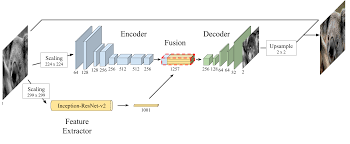

There are also various other techniques you could follow to colorize black and white images with deep learning

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import set_random_seed
import tensorflow as tf

set_random_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)
set_random_seed(2)
np.random.seed(1)

print(os.listdir("../input/dataset/dataset_updated/"))

['validation_set', 'training_set']


In [37]:
ImagePath="../input/dataset/dataset_updated/training_set/painting/"

(224, 224, 3)

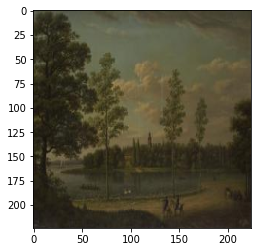

In [38]:
img = cv2.imread(ImagePath+"1179.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

**There are two techniques to generate colored image from its gray scaled form:-**
1. **Turn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value**.
2. **Turn the RGB image into LUV image, then separate the L value and UV value from the image and then train the model to predict the UV value**.

Here I have used Lab value to colorize the image, where  L stands for lightness, and a and b for the color spectra green–red and blue–yellow.**

## NOTE:-

* Our Dataset consists of all coloured images and we have to use black and white image for training the model therefore we would be converting the colored image to grayScaled image and then turning it to RGB format to get the complete black and white image conversion.
* I have also used Opencv to read the image but Opencv reads the image in BGR format, so we need to convert the image to RGB format first before turning it to greyscale.
* You could also avoid using Opencv.
* There are many lines of code which you would to be see in traditional colorizing technique but I have commented out those for better results in my case and also I have explained the reason with comments why that part of the code is used in traditional Colorizing technique.

In [39]:
HEIGHT=224
WIDTH=224
ImagePath="../input/dataset/dataset_updated/training_set/painting/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [40]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [41]:
#X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)

In [42]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [43]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [44]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 224, 224, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 4640        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [45]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
Model_Colourization.fit_generator(
    GenerateInputs(X_,y_), 
    epochs=53,
    verbose=1,
    steps_per_epoch=38,  # this must match your data length
    shuffle=True
)


Epoch 1/53
38/38 [==============================] - 2s 54ms/step - loss: 0.0875
Epoch 2/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0192
Epoch 3/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0094
Epoch 4/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0022
Epoch 5/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0016
Epoch 6/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0035
Epoch 7/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0082
Epoch 8/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0036
Epoch 9/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 10/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0049
Epoch 11/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0297
Epoch 12/53
38/38 [==============================] - 1s 20ms/step - loss: 0.0131
Epoch 13/53
38/38 [==================

In [46]:
TestImagePath="../input/dataset/dataset_updated/training_set/iconography/"

In [47]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [48]:
ImagePath=TestImagePath+"15.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

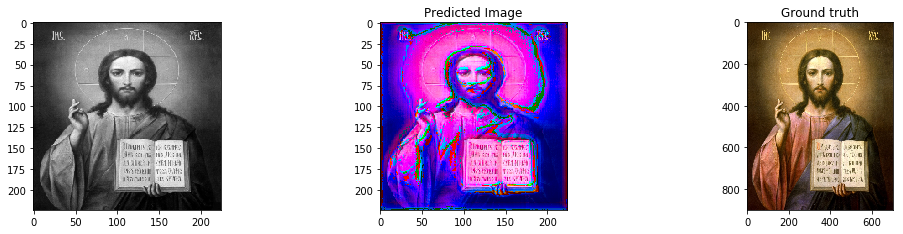

In [49]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"15.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [50]:
ImagePath=TestImagePath+"314.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

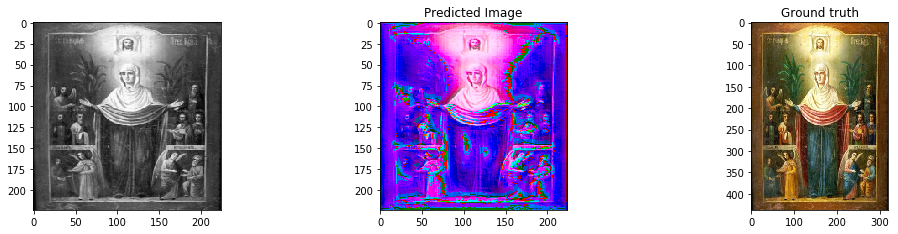

In [51]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"314.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [52]:
ImagePath=TestImagePath+"698.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_2 = Model_Colourization.predict(image_for_test)
Prediction_2 = Prediction_2*128
Prediction_2=Prediction_2.reshape(224,224,2)

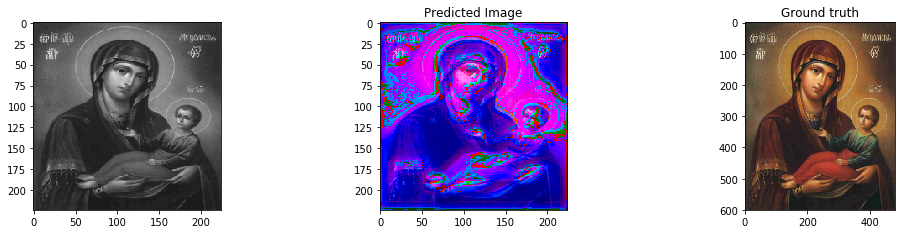

In [53]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"698.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_2
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [54]:
TestImagePath="../input/dataset/dataset_updated/training_set/sculpture/240.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,2)

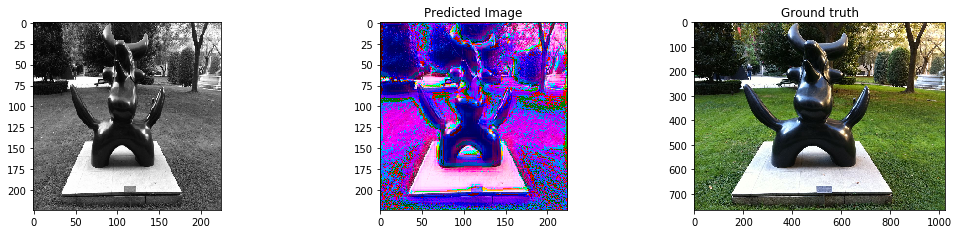

In [55]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [56]:
TestImagePath="../input/dataset/dataset_updated/training_set/painting/1601.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,2)

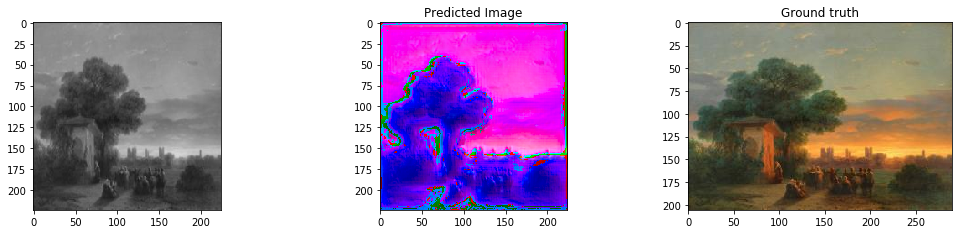

In [57]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [58]:
TestImagePath="../input/dataset/dataset_updated/training_set/painting/1577.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,2)

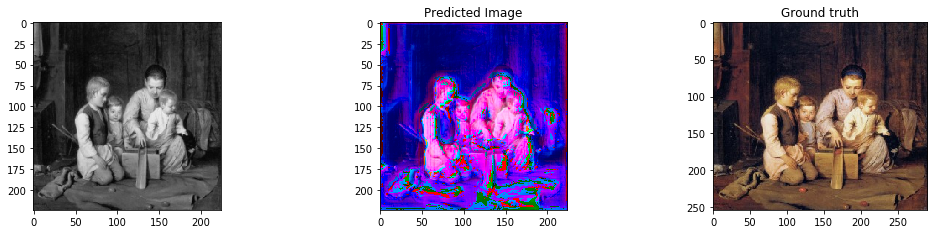

In [59]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

**CONCLUSION**
* **The Model is able to identify the correct pattern or shades in which the color must be filled or we can say the model is able to separate out the portions which is needed to be colored  to get the colorized image but is not able to predict the accurate color for that shade or portion all the time with respect to the ground truth image.**
* **I hope With the Help of feature extraction with ResNet this problem could be solved easily.**
* **The Resuls also reflects the actual requirement for GAN and other image colorization techniques.**